In [1]:
#Mediante https://www.tensorflow.org/tutorials/structured_data/time_series
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from tensorflow.keras import layers
from keras.layers import Dense,LSTM
from keras.models import Sequential, Model

Using TensorFlow backend.


In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [3]:
dataMeteoCellId5570 = pd.read_csv('transformed_data/mi_CellId_extra_info_10min_5570.csv', index_col=0)
dataMeteoCellId5570

,week,weekday,hour,minute,CellID,smsin,smsout,callin,callout,internet,idx,relativeHumidity,precipitation,temperature,windSpeed
12997,46,5,0,0,5570,4.557095,3.391683,3.167606,3.485656,264.667864,47088.0,88.0,0.0,9.900000,1.00
13003,46,5,0,10,5570,10.274989,2.873772,0.528183,0.382381,229.886522,47089.0,88.0,0.0,9.916667,0.95
13009,46,5,0,20,5570,11.480552,4.941439,2.890758,0.124759,260.543188,47090.0,88.0,0.0,9.933333,0.90
13015,46,5,0,30,5570,3.484011,4.717001,0.166728,0.784425,241.326109,47091.0,88.0,0.0,9.950000,0.85
13021,46,5,0,40,5570,4.341397,2.348783,1.054961,0.108556,253.345193,47092.0,88.0,0.0,9.966667,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37165,50,4,23,20,5570,2.851781,9.329604,3.924049,5.176218,301.659528,51116.0,100.0,0.0,0.900000,0.70
37171,50,4,23,30,5570,10.727198,26.561234,4.129382,4.310584,325.776125,51117.0,100.0,0.0,0.900000,0.70
37177,50,4,23,40,5570,11.557735,12.126945,3.638678,4.045915,316.402061,51118.0,100.0,0.0,0.900000,0.70
37183,50,4,23,50,5570,12.228045,7.805717,1.505751,4.205687,310.504314,51119.0,100.0,0.0,0.900000,0.70


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(dataMeteoCellId5570)

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 2823 #len(dataMeteoCellId5570) * 0.7

In [7]:
TRAIN_SPLIT

2823

In [8]:
tf.random.set_seed(0)

In [9]:
uni_data5570 = dataMeteoCellId5570['internet']
uni_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
uni_data5570.head()

idx
0.0    264.667864
1.0    229.886522
2.0    260.543188
3.0    241.326109
4.0    253.345193
Name: internet, dtype: float64

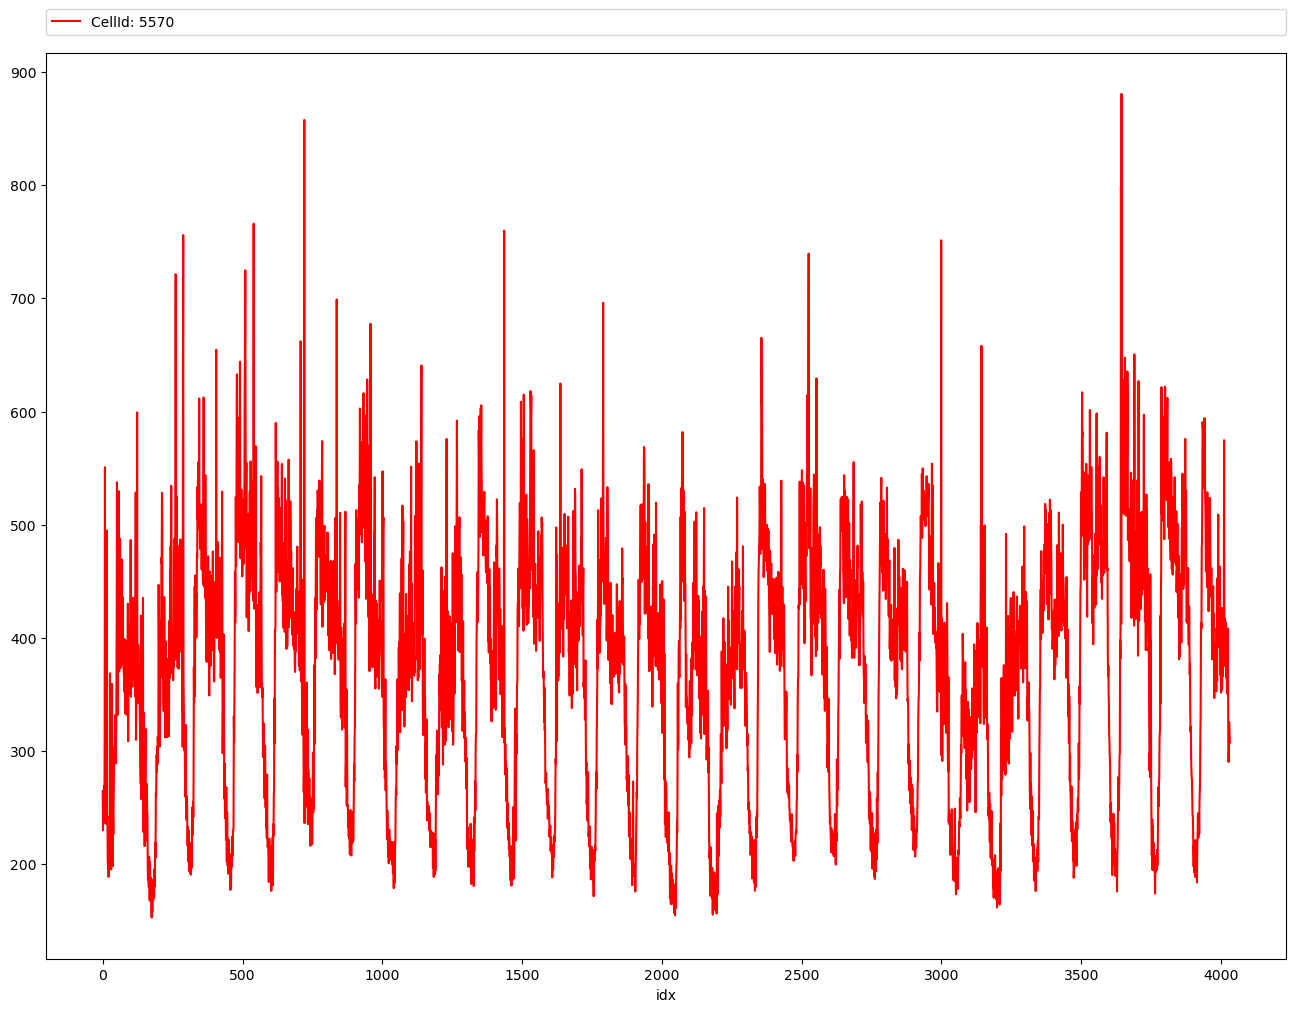

In [10]:
plt.figure(figsize=(16, 12), dpi=100) 

uni_data5570.plot(kind='line',x='index',y='internet', color='red', label = "CellId: 5570")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('Prueba.png',bbox_inches='tight')

plt.show()

In [11]:
uni_data = uni_data5570

<AxesSubplot:xlabel='idx'>

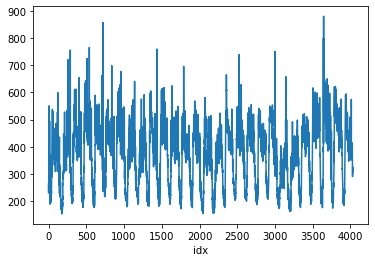

In [12]:
uni_data.plot()

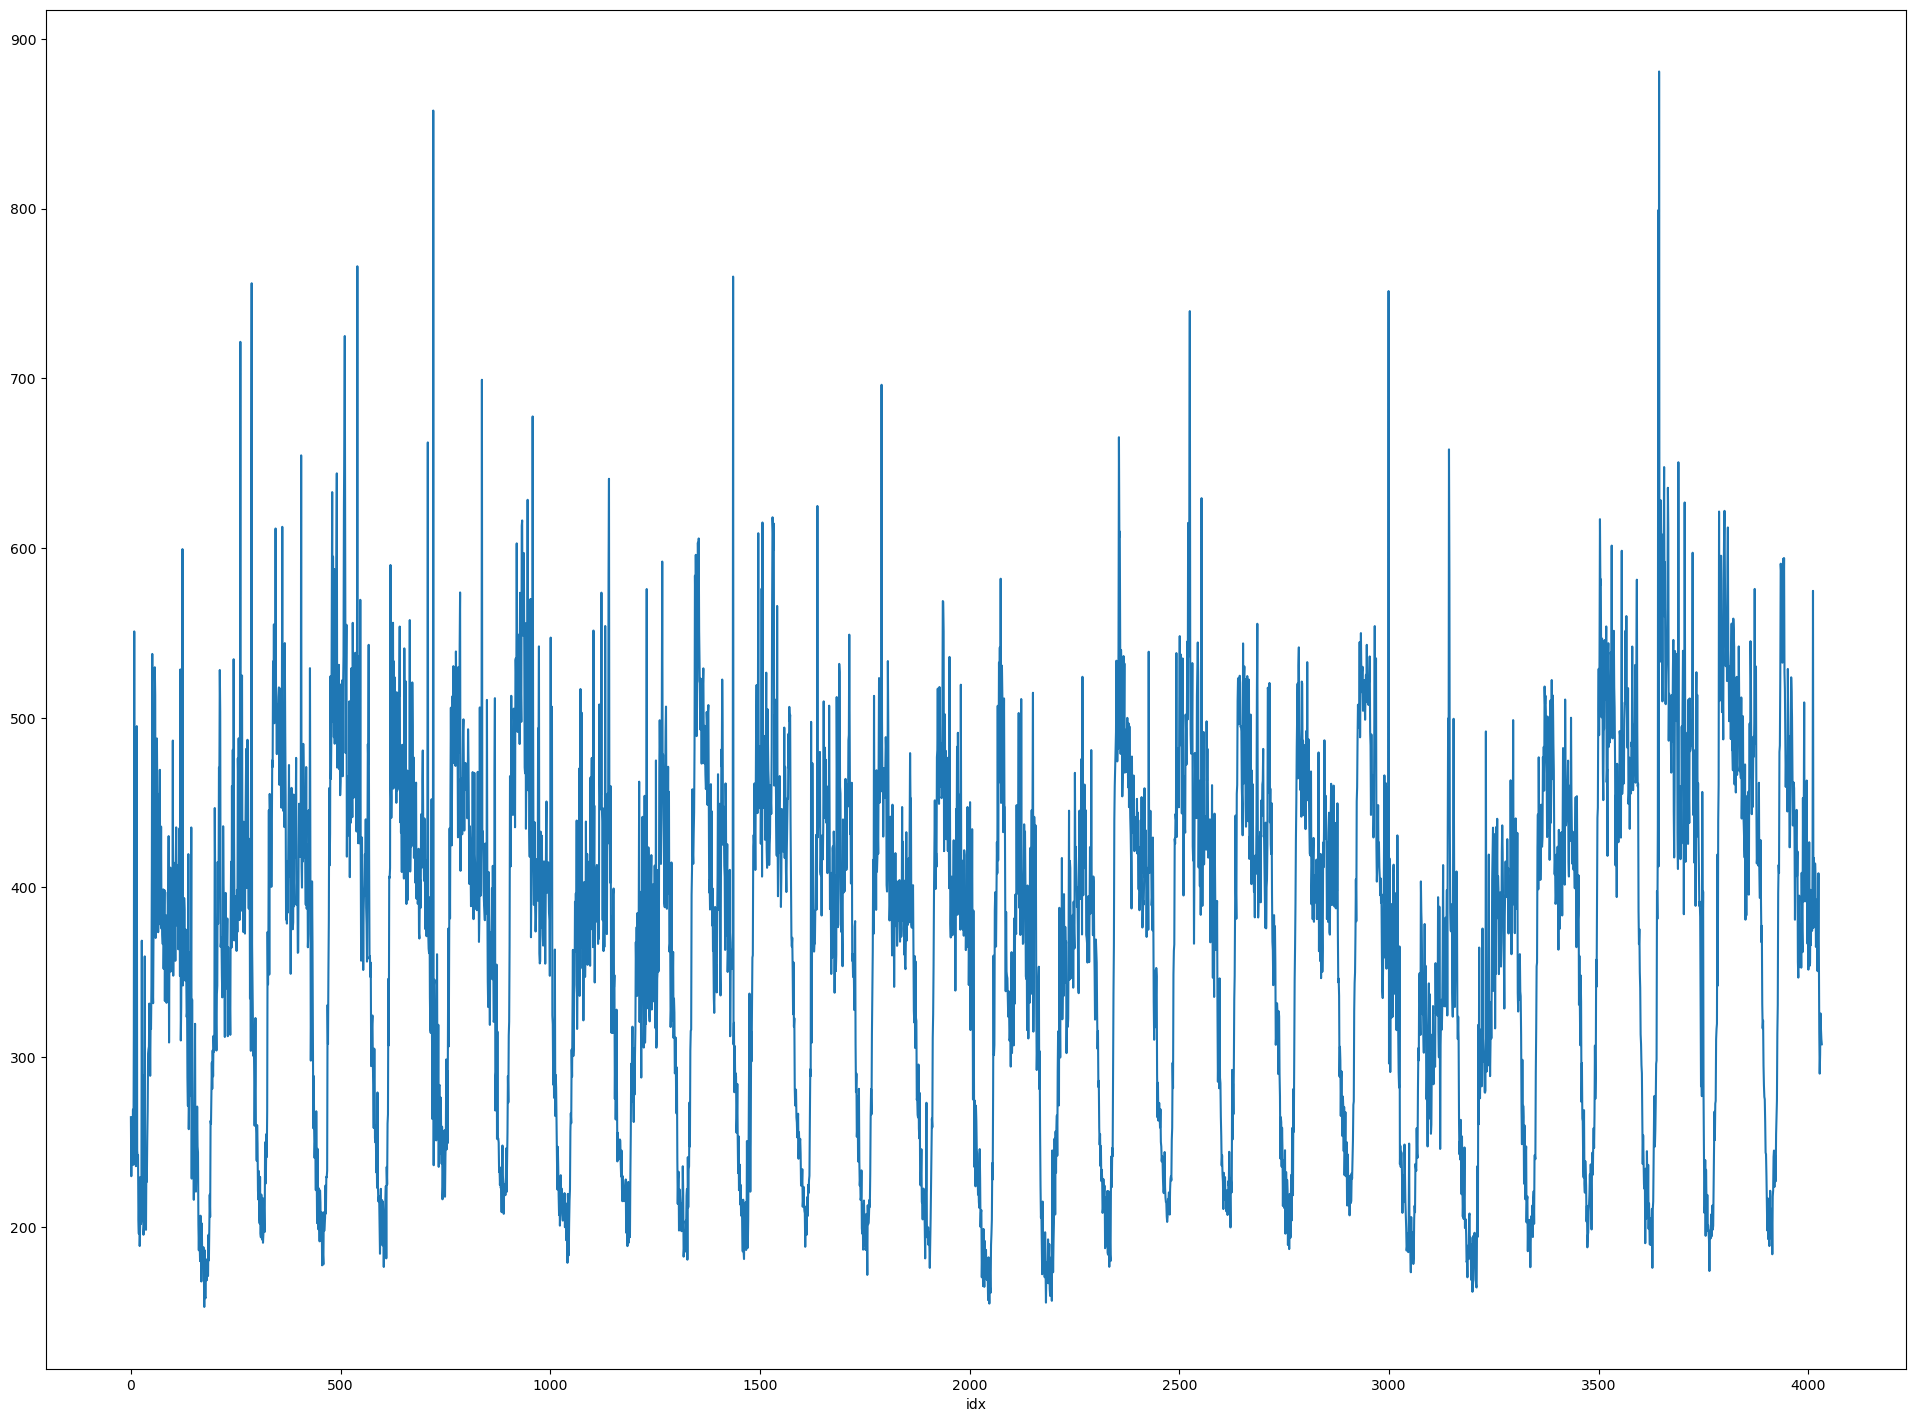

In [13]:
plt.figure(figsize=(24, 18), dpi=100) 
uni_data.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba5570.png',bbox_inches='tight')
plt.show()

In [14]:
uni_data

idx
0.0       264.667864
1.0       229.886522
2.0       260.543188
3.0       241.326109
4.0       253.345193
             ...    
4028.0    301.659528
4029.0    325.776125
4030.0    316.402061
4031.0    310.504314
4032.0    307.614187
Name: internet, Length: 4033, dtype: float64

In [15]:
uni_data = uni_data.values

In [16]:
uni_data

array([264.66786393, 229.88652229, 260.54318779, ..., 316.40206067,
       310.5043138 , 307.61418713])

In [17]:
uni_data
len(uni_data)

4033

In [18]:
from sklearn.preprocessing import MinMaxScaler
feature = ['idx', 'internet']
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(dataMeteoCellId5570[feature])

In [19]:
uni_data = DataScaledMeteoCellId5570

In [20]:
uni_data

array([[0.00000000e+00, 1.53608895e-01],
       [2.48015873e-04, 1.05827408e-01],
       [4.96031746e-04, 1.47942548e-01],
       ...,
       [9.99503968e-01, 2.24679669e-01],
       [9.99751984e-01, 2.16577534e-01],
       [1.00000000e+00, 2.12607171e-01]])

In [21]:
uni_data[:,1]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [22]:
univariate_past_history = 36
univariate_future_target = 6

x_train_uni, y_train_uni = univariate_data(uni_data[:,1], 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data[:,1], TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [23]:
len(x_train_uni)

2787

In [24]:
len(y_train_uni)

2787

In [25]:
len(x_val_uni)

1168

In [26]:
x_train_uni

array([[[0.1536089 ],
        [0.10582741],
        [0.14794255],
        ...,
        [0.28376098],
        [0.0971225 ],
        [0.11293881]],

       [[0.10582741],
        [0.14794255],
        [0.12154274],
        ...,
        [0.0971225 ],
        [0.11293881],
        [0.06245038]],

       [[0.14794255],
        [0.12154274],
        [0.13805417],
        ...,
        [0.11293881],
        [0.06245038],
        [0.12014381]],

       ...,

       [[0.5191737 ],
        [0.53388186],
        [0.46748642],
        ...,
        [0.36819976],
        [0.31384855],
        [0.3642017 ]],

       [[0.53388186],
        [0.46748642],
        [0.45398709],
        ...,
        [0.31384855],
        [0.3642017 ],
        [0.37962966]],

       [[0.46748642],
        [0.45398709],
        [0.4276199 ],
        ...,
        [0.3642017 ],
        [0.37962966],
        [0.31176572]]])

In [27]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Internet charge to predict')
print (y_train_uni[0])

Single window of past history
[[0.1536089 ]
 [0.10582741]
 [0.14794255]
 [0.12154274]
 [0.13805417]
 [0.15982917]
 [0.11504388]
 [0.21989066]
 [0.54677916]
 [0.13502684]
 [0.27305958]
 [0.23093229]
 [0.11394433]
 [0.37100539]
 [0.47012004]
 [0.1264425 ]
 [0.12112494]
 [0.12291003]
 [0.07036461]
 [0.05923647]
 [0.104729  ]
 [0.04932195]
 [0.06512679]
 [0.10498522]
 [0.06710139]
 [0.07030829]
 [0.29647422]
 [0.12437053]
 [0.13502135]
 [0.18753755]
 [0.0584375 ]
 [0.06531346]
 [0.16847382]
 [0.28376098]
 [0.0971225 ]
 [0.11293881]]

 Target Internet charge to predict
0.20862030894690872


In [28]:
def create_time_steps(length):
    return list(range(-length, 0))

In [29]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+3)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

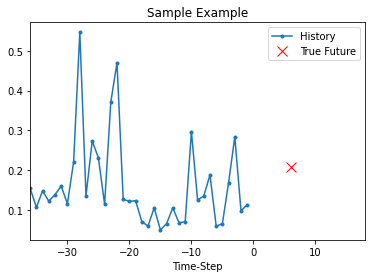

In [30]:
show_plot([x_train_uni[0], y_train_uni[0]], 6, 'Sample Example')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

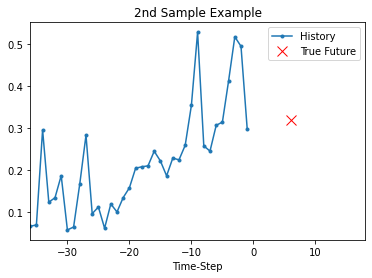

In [31]:
show_plot([x_train_uni[24], y_train_uni[24]], 6, '2nd Sample Example')

In [32]:
import requests

def telegram_bot_sendtext(bot_message):
    
    bot_token = '1441415905:AAGslC5ZnjlBYHnFYP-9KAH-BPAwnqJc1X4'
    bot_chatID = '1071238666'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

    response = requests.get(send_text)

    return response.json()
    
maquina = "VM 5570-36-0-6 ONLINE"
    
test = telegram_bot_sendtext(maquina + " reiniciada")
print(test)

{'ok': True, 'result': {'message_id': 2614, 'from': {'id': 1441415905, 'is_bot': True, 'first_name': 'Tfmbot', 'username': 'Tfmdl_bot'}, 'chat': {'id': 1071238666, 'first_name': 'man', 'last_name': 'cham', 'username': 'mancham8', 'type': 'private'}, 'date': 1610026931, 'text': 'VM 5570-36-0-6 ONLINE reiniciada'}}


# LR GLOBAL

In [33]:
LR_GLOBAL = 1

# Recurrent neural network con cambio de variables con la CellId 5570 -LSTM

In [34]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 36, 16)            1152      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)         

In [35]:
dfModel5570mse = pd.DataFrame(data = model5570mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileLstmMulti2 = 'transformed_data/model5570-36-0-6-mse_LSTM_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570mse.to_csv(fileLstmMulti2, encoding='utf-8')

In [36]:
dfModel5570ArrayAcc = pd.DataFrame(data = model5570ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
dfModel5570ArrayAcc.to_csv('transformed_data/model5570-36-0-6-acc_LSTM_' + str(LR_GLOBAL).zfill(1) + '.csv', encoding='utf-8')

In [37]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Single MSE LSTM")

# Recurrent neural network con cambio de variables con la CellId 5570 - GRU

In [38]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 36, 16)            912       
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_1 (Dense)             

In [39]:
dfModel5570mse = pd.DataFrame(data = model5570mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileGruMulti2 = 'transformed_data/model5570-36-0-6-mse_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570mse.to_csv(fileGruMulti2, encoding='utf-8')

In [40]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Single MSE GRU")

In [41]:
dfModel5570ArrayAcc = pd.DataFrame(data = model5570ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
dfModel5570ArrayAcc.to_csv('transformed_data/model5570-36-0-6-acc_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv', encoding='utf-8')

# Recurrent neural network con cambio de variables con la CellId 5570 multivariate time series

In [42]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet'] #		temperature	windSpeed

In [43]:
multi_data5570 = dataMeteoCellId5570[features_considered]
multi_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
multi_data5570.head()

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
0.0,9.900000,88.0,0.0,1.00,264.667864
1.0,9.916667,88.0,0.0,0.95,229.886522
2.0,9.933333,88.0,0.0,0.90,260.543188
3.0,9.950000,88.0,0.0,0.85,241.326109
4.0,9.966667,88.0,0.0,0.80,253.345193


In [44]:
len(multi_data5570)

4033

In [45]:
dataset = multi_data5570.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

<Figure size 2400x1800 with 0 Axes>

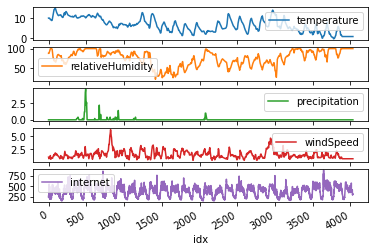

In [46]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5570.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [47]:
multi_data5570

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
0.0,9.900000,88.0,0.0,1.00,264.667864
1.0,9.916667,88.0,0.0,0.95,229.886522
2.0,9.933333,88.0,0.0,0.90,260.543188
3.0,9.950000,88.0,0.0,0.85,241.326109
4.0,9.966667,88.0,0.0,0.80,253.345193
...,...,...,...,...,...
4028.0,0.900000,100.0,0.0,0.70,301.659528
4029.0,0.900000,100.0,0.0,0.70,325.776125
4030.0,0.900000,100.0,0.0,0.70,316.402061


In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(multi_data5570)

In [49]:
dataset = DataScaledMeteoCellId5570

In [50]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [51]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [52]:
dataset[:, 4]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [53]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [54]:
#univariate_past_history = 36
#univariate_future_target = 6
past_history = 36
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [55]:
x_train_multi[0]

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       [0.67666667, 0.84615385, 0.        , 0.07758621, 0.12154274],
       [0.67777778, 0.84615385, 0.        , 0.06896552, 0.13805417],
       [0.67888889, 0.84615385, 0.        , 0.06034483, 0.15982917],
       [0.68      , 0.84615385, 0.        , 0.05172414, 0.11504388],
       [0.67777778, 0.85470085, 0.        , 0.05747126, 0.21989066],
       [0.67555556, 0.86324786, 0.        , 0.06321839, 0.54677916],
       [0.67333333, 0.87179487, 0.        , 0.06896552, 0.13502684],
       [0.67111111, 0.88034188, 0.        , 0.07471264, 0.27305958],
       [0.66888889, 0.88888889, 0.        , 0.08045977, 0.23093229],
       [0.66666667, 0.8974359 , 0.        , 0.0862069 , 0.11394433],
       [0.66555556, 0.90598291, 0.        , 0.0862069 , 0.37100539],
       [0.66444444, 0.91452991, 0.

In [56]:
y_train_multi[0]

0.20862030894690872

In [57]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)

                #model5570Array.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], simple_lstm, history_lstm])
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 36, 16)            1152      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)         

In [58]:
dfModel5570mse = pd.DataFrame(data = model5570mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileLstmMulti2 = 'transformed_data/model5570multi-36-0-6-TRPW-mse_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570mse.to_csv(fileLstmMulti2, encoding='utf-8')

In [59]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Multi mse LSTM")

In [60]:
dfModel5570ArrayAcc = pd.DataFrame(data = model5570ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileLstmMulti = 'transformed_data/model5570multi-36-0-6-TRPW-acc_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570ArrayAcc.to_csv(fileLstmMulti, encoding='utf-8')

In [61]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti)
except:
    telegram_bot_sendtext(maquina + " creado Multi acc LSTM")

# Recurrent neural network con cambio de hiperparametros con la CellId 5570 multivariate time series - GRU

In [62]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [63]:
multi_data5570 = dataMeteoCellId5570[features_considered]
multi_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
multi_data5570.head()

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
0.0,9.900000,88.0,0.0,1.00,264.667864
1.0,9.916667,88.0,0.0,0.95,229.886522
2.0,9.933333,88.0,0.0,0.90,260.543188
3.0,9.950000,88.0,0.0,0.85,241.326109
4.0,9.966667,88.0,0.0,0.80,253.345193


In [64]:
len(multi_data5570)

4033

<Figure size 2400x1800 with 0 Axes>

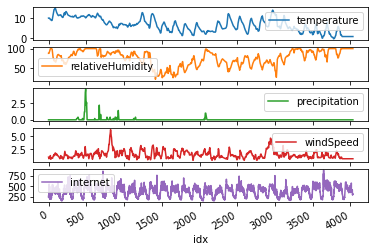

In [65]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5570.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [66]:
multi_data5570

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
0.0,9.900000,88.0,0.0,1.00,264.667864
1.0,9.916667,88.0,0.0,0.95,229.886522
2.0,9.933333,88.0,0.0,0.90,260.543188
3.0,9.950000,88.0,0.0,0.85,241.326109
4.0,9.966667,88.0,0.0,0.80,253.345193
...,...,...,...,...,...
4028.0,0.900000,100.0,0.0,0.70,301.659528
4029.0,0.900000,100.0,0.0,0.70,325.776125
4030.0,0.900000,100.0,0.0,0.70,316.402061


In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(multi_data5570)

In [68]:
dataset = DataScaledMeteoCellId5570

In [69]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [70]:
len(dataset)

4033

In [71]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [72]:
dataset[:, 4]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [73]:
dataset #dataset[:, [0,1,2,3]]

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [74]:
#univariate_past_history = 36
#univariate_future_target = 6
past_history = 36
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [75]:
len(x_train_multi)

2787

In [76]:
len(x_val_multi)

1168

In [77]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 36, 16)            912       
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_1 (Dense)             

In [78]:
dfModel5570mse = pd.DataFrame(data = model5570mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileGruMulti2 = 'transformed_data/model5570multi-36-0-6-TRPW-mse_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570mse.to_csv(fileGruMulti2, encoding='utf-8')

In [79]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Multi mse GRU")

In [80]:
dfModel5570ArrayAcc = pd.DataFrame(data = model5570ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileGruMulti = 'transformed_data/model5570multi-36-0-6-TRPW-acc_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570ArrayAcc.to_csv(fileGruMulti, encoding='utf-8')

In [81]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti)
except:
    telegram_bot_sendtext(maquina + " creado Multi acc GRU")

# Recurrent neural network con cambio de variables con la CellId 5570 multivariate time series SEPARADO

In [82]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet'] #		temperature	windSpeed

In [83]:
multi_data5570 = dataMeteoCellId5570[features_considered]
multi_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
multi_data5570.head()

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
0.0,9.900000,88.0,0.0,1.00,264.667864
1.0,9.916667,88.0,0.0,0.95,229.886522
2.0,9.933333,88.0,0.0,0.90,260.543188
3.0,9.950000,88.0,0.0,0.85,241.326109
4.0,9.966667,88.0,0.0,0.80,253.345193


In [84]:
len(multi_data5570)

4033

In [85]:
dataset = multi_data5570.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

<Figure size 2400x1800 with 0 Axes>

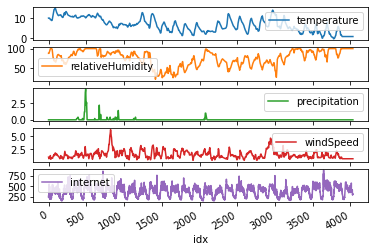

In [86]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5570.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [87]:
multi_data5570

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
0.0,9.900000,88.0,0.0,1.00,264.667864
1.0,9.916667,88.0,0.0,0.95,229.886522
2.0,9.933333,88.0,0.0,0.90,260.543188
3.0,9.950000,88.0,0.0,0.85,241.326109
4.0,9.966667,88.0,0.0,0.80,253.345193
...,...,...,...,...,...
4028.0,0.900000,100.0,0.0,0.70,301.659528
4029.0,0.900000,100.0,0.0,0.70,325.776125
4030.0,0.900000,100.0,0.0,0.70,316.402061


In [88]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(multi_data5570)

In [89]:
dataset = DataScaledMeteoCellId5570

In [90]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [91]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [92]:
dataset[:, 4]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [93]:
dataset[:, [0,1,2,3]]

array([[0.67333333, 0.84615385, 0.        , 0.10344828],
       [0.67444444, 0.84615385, 0.        , 0.09482759],
       [0.67555556, 0.84615385, 0.        , 0.0862069 ],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414],
       [0.07333333, 1.        , 0.        , 0.05172414],
       [0.07333333, 1.        , 0.        , 0.05172414]])

In [94]:
#univariate_past_history = 36
#univariate_future_target = 6
past_history = 36
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [95]:
x_train_multi[0]

array([[0.67333333, 0.84615385, 0.        , 0.10344828],
       [0.67444444, 0.84615385, 0.        , 0.09482759],
       [0.67555556, 0.84615385, 0.        , 0.0862069 ],
       [0.67666667, 0.84615385, 0.        , 0.07758621],
       [0.67777778, 0.84615385, 0.        , 0.06896552],
       [0.67888889, 0.84615385, 0.        , 0.06034483],
       [0.68      , 0.84615385, 0.        , 0.05172414],
       [0.67777778, 0.85470085, 0.        , 0.05747126],
       [0.67555556, 0.86324786, 0.        , 0.06321839],
       [0.67333333, 0.87179487, 0.        , 0.06896552],
       [0.67111111, 0.88034188, 0.        , 0.07471264],
       [0.66888889, 0.88888889, 0.        , 0.08045977],
       [0.66666667, 0.8974359 , 0.        , 0.0862069 ],
       [0.66555556, 0.90598291, 0.        , 0.0862069 ],
       [0.66444444, 0.91452991, 0.        , 0.0862069 ],
       [0.66333333, 0.92307692, 0.        , 0.0862069 ],
       [0.66222222, 0.93162393, 0.        , 0.0862069 ],
       [0.66111111, 0.94017094,

In [96]:
y_train_multi[0]

0.20862030894690872

In [97]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.LSTM(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 36, 16)            1152      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)         

In [98]:
dfModel5570mse = pd.DataFrame(data = model5570mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileLstmMulti2 = 'transformed_data/model5570multi-36-0-6-TRPW-sep-mse_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570mse.to_csv(fileLstmMulti2, encoding='utf-8')

In [99]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Multi mse LSTM")

In [100]:
dfModel5570ArrayAcc = pd.DataFrame(data = model5570ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileLstmMulti = 'transformed_data/model5570multi-36-0-6-TRPW-sep-acc_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570ArrayAcc.to_csv(fileLstmMulti, encoding='utf-8')

In [101]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileLstmMulti)
except:
    telegram_bot_sendtext(maquina + " creado Multi acc LSTM")

# Recurrent neural network con cambio de hiperparametros con la CellId 5570 multivariate time series - GRU SEPARADO

In [102]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [103]:
multi_data5570 = dataMeteoCellId5570[features_considered]
multi_data5570.index = dataMeteoCellId5570['idx'] - 47088.0
multi_data5570.head()

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
0.0,9.900000,88.0,0.0,1.00,264.667864
1.0,9.916667,88.0,0.0,0.95,229.886522
2.0,9.933333,88.0,0.0,0.90,260.543188
3.0,9.950000,88.0,0.0,0.85,241.326109
4.0,9.966667,88.0,0.0,0.80,253.345193


In [104]:
len(multi_data5570)

4033

<Figure size 2400x1800 with 0 Axes>

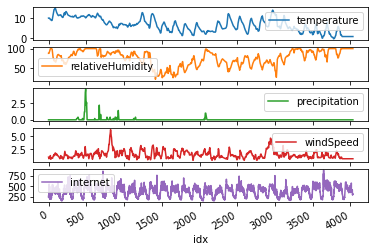

In [105]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5570.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [106]:
multi_data5570

,temperature,relativeHumidity,precipitation,windSpeed,internet
idx,,,,,
0.0,9.900000,88.0,0.0,1.00,264.667864
1.0,9.916667,88.0,0.0,0.95,229.886522
2.0,9.933333,88.0,0.0,0.90,260.543188
3.0,9.950000,88.0,0.0,0.85,241.326109
4.0,9.966667,88.0,0.0,0.80,253.345193
...,...,...,...,...,...
4028.0,0.900000,100.0,0.0,0.70,301.659528
4029.0,0.900000,100.0,0.0,0.70,325.776125
4030.0,0.900000,100.0,0.0,0.70,316.402061


In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5570 = scaler.fit_transform(multi_data5570)

In [108]:
dataset = DataScaledMeteoCellId5570

In [109]:
dataset

array([[0.67333333, 0.84615385, 0.        , 0.10344828, 0.1536089 ],
       [0.67444444, 0.84615385, 0.        , 0.09482759, 0.10582741],
       [0.67555556, 0.84615385, 0.        , 0.0862069 , 0.14794255],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414, 0.22467967],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21657753],
       [0.07333333, 1.        , 0.        , 0.05172414, 0.21260717]])

In [110]:
len(dataset)

4033

In [111]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [112]:
dataset[:, 4]

array([0.1536089 , 0.10582741, 0.14794255, ..., 0.22467967, 0.21657753,
       0.21260717])

In [113]:
dataset[:, [0,1,2,3]]

array([[0.67333333, 0.84615385, 0.        , 0.10344828],
       [0.67444444, 0.84615385, 0.        , 0.09482759],
       [0.67555556, 0.84615385, 0.        , 0.0862069 ],
       ...,
       [0.07333333, 1.        , 0.        , 0.05172414],
       [0.07333333, 1.        , 0.        , 0.05172414],
       [0.07333333, 1.        , 0.        , 0.05172414]])

In [114]:
#univariate_past_history = 36
#univariate_future_target = 6
past_history = 36
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [115]:
len(x_train_multi)

2787

In [116]:
len(x_val_multi)

1168

In [ ]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5570ArrayAcc = []
model5570mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[LR_GLOBAL])
                simple_lstm = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_lstm.add(tf.keras.layers.GRU(nodo))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_lstm.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5570ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], score[0], score[1]])
                
                test_predictions = simple_lstm.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions).numpy()
                model5570mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[LR_GLOBAL], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 36, 16)            912       
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense_1 (Dense)             

In [ ]:
dfModel5570mse = pd.DataFrame(data = model5570mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileGruMulti2 = 'transformed_data/model5570multi-36-0-6-TRPW-sep-mse_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570mse.to_csv(fileGruMulti2, encoding='utf-8')

In [ ]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti2)
except:
    telegram_bot_sendtext(maquina + " creado Multi mse GRU")

In [ ]:
dfModel5570ArrayAcc = pd.DataFrame(data = model5570ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileGruMulti = 'transformed_data/model5570multi-36-0-6-TRPW-sep-acc_GRU_' + str(LR_GLOBAL).zfill(1) + '.csv'
dfModel5570ArrayAcc.to_csv(fileGruMulti, encoding='utf-8')

In [ ]:
try:
    telegram_bot_sendtext(maquina + " creado:" + fileGruMulti)
except:
    telegram_bot_sendtext(maquina + " creado Multi acc GRU")

# Codigo para recuperarse de problemas con GPU

# gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])